# Incidence of Covid-19 and Neighborhood Parks

The world is currently in the grip of a global pandemic of SARS-CoV-2. Countries, and public health departments in particular, have been fairly open about infection data in order to give the public the information necessary to make behavioral choices to protect themselves and their communities. One question community members (and health department officials, as well) may have is whether parks are dangerous. That is, do parks increase the amount of COVID-19 in a neighborhood. The proposed project will explore this question using location-tagged COVID-19 infection data paired with Foursquare trending venue data. We ask, is the level of COVID-19 infection in a neighborhood correlated with the kinds of activity available in that neighborhood? 

For instance, if we find the number of parks in walking distance of a neighborhood increases the amount of COVID-19 cases, we evidence (though not proof!) for some causal link, and perhaps health officials and community members should take a further look at parks a vector for disease.

The results of this study will help public health stakeholders calibrate their public stances. For instance, if we find a positive or no correlation, the public health department may choose to take specific interventions (e.g., increased targeted advertising) so that the residents are aware of the heighten risk in their neighborhood. If we find a negative correlation because COVID-19 case count and activity, then stakeholders will know that the current strategy is currently working, and for instance, certain restrictions could be relaxed---e.g., lessening restrictions on park access.


## Introducing the data

We will explore the incidence of COVID-19 and the accessibility of parks in the city of Toronto. The Toronto public health department publishes comprehensive data about COVID-19, including data about number of positive cases by neighborhood (see https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/). We will be able to take the raw COVID-19 cases by neighborhood data and pair it with venue data using the Foursquare API (documented here: https://developer.foursquare.com/docs/api-reference/venues/trending). We can then ask a variety of questions that will get at the larger question at hand, for instance, is the number of parks with walking distance of a neighborhood predictive of the prevalence of COVID-19 in that neighborhood.

### Constructing a Toronto case count dataset
We retrieved the COVID-19 case count by neighborhood data for the day of June 5th, 2020, which we show below. We need to add geospatial data to this set, which is what we will do in this section. For readers no interested in the process of data construction, skip to end of the section to see the resulting dataset.

In [18]:
import pandas as pd

covid_df = pd.read_csv('toronto_covid_by_neighborhood_6-5-20.csv')
covid_df.head(20)

,Neighbourhood Name,Case Count
0,Yorkdale-Glen Park,120
1,York University Heights,286
2,Yonge-St.Clair,19
3,Yonge-Eglinton,12
4,Wychwood,68
5,Woodbine-Lumsden,19
6,Woodbine Corridor,17
7,Woburn,231
8,Willowridge-Martingrove-Richview,61
9,Willowdale West,35


We need to pair these data with geospatial coordinates in order to query the Foursquare API. To do this, we start by scraping Wikipedia for the postal codes of each borough and neighborhood, and then crossreferencing the postal codes with a CSV of postal code coordinates.

In [19]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df = dfs[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


We have to do a bit of cleaning the data in order to join our these data with our COVID neighborhood data.

In [20]:
# Toss rows with unassigned Borough
df = df[df.Borough != 'Not assigned']

# Explode df so that Neighborhoods under the same postal code get their own row.

df = df.assign(Neighborhood=df.Neighborhood.str.split(',')).explode('Neighborhood')

In [21]:
# Join covid data frame and our neighborhood data on Neighborhood
covid_df.rename(columns={"Neighbourhood Name":"Neighborhood"}, inplace=True)

df = df.join(covid_df.set_index('Neighborhood'), on='Neighborhood')

In [22]:
df = df.dropna()
df.head()

,Postal Code,Borough,Neighborhood,Case Count
3,M4A,North York,Victoria Village,37.0
4,M5A,Downtown Toronto,Regent Park,23.0
9,M1B,Scarborough,Malvern,158.0
23,M6C,York,Humewood-Cedarvale,20.0
27,M1E,Scarborough,Guildwood,101.0


We combine our case count data by neighborhood with spatial coordinates, which will allow us to plot our data and crossreference different kinds of venues on Foursquare.

In [23]:
df2 = pd.read_csv("Geospatial_Coordinates.csv")

In [24]:
df = df.join(df2.set_index('Postal Code'), on='Postal Code')
df.to_csv('casecount_latlong.csv', encoding='utf-8', index = False)
df.head(20)

,Postal Code,Borough,Neighborhood,Case Count,Latitude,Longitude
3,M4A,North York,Victoria Village,37.0,43.725882,-79.315572
4,M5A,Downtown Toronto,Regent Park,23.0,43.654260,-79.360636
9,M1B,Scarborough,Malvern,158.0,43.806686,-79.194353
23,M6C,York,Humewood-Cedarvale,20.0,43.693781,-79.428191
27,M1E,Scarborough,Guildwood,101.0,43.763573,-79.188711
30,M4E,East Toronto,The Beaches,13.0,43.676357,-79.293031
36,M1G,Scarborough,Woburn,231.0,43.770992,-79.216917
46,M2H,North York,Hillcrest Village,58.0,43.803762,-79.363452
47,M3H,North York,Bathurst Manor,98.0,43.754328,-79.442259
48,M4H,East York,Thorncliffe Park,85.0,43.705369,-79.349372


Now that we have our final case cound dataset, we can extend that data with data about activity in those neighborhoods using Foursquare trending venue data.

### Adding Foursquare trending venue data

Foursquare provides an API endpoint allowing us to search for venues with X distance of a point that bear a particular category. For each neighborhood for which we have case count data, we will ask how many parks are within 2000m (roughly walking distance) of the center of that neighborhood. We can then crossreference this data with the COVID data we constructed above.

First, we set our Foursquare credentials.

In [246]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


We define a function that will retrieve the number of parks within 2000m of the given neighborhood, writing that data to a new DataFrame.

In [28]:
import requests

def getParkCount(names, latitudes, longitudes, radius=2000):
    
    LIMIT = 100
    parks = []
    CATEGORY = '4bf58dd8d48988d163941735' #Park
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CATEGORY)
            
    
        # make the GET request
        result = requests.get(url).json()['response']['totalResults']
        
        parks.append([(
            name, 
            #lat, 
            #lng, 
            result)])
    

    parks_df = pd.DataFrame([item for parks in parks for item in parks])
    parks_df.columns = ['Neighborhood', 
                  #'Neighborhood Latitude', 
                  #'Neighborhood Longitude', 
                  'Parks']
    
    return(parks_df)

In [29]:
parks_df = getParkCount(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Victoria Village
Regent Park
Malvern
Humewood-Cedarvale
Guildwood
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Little Portugal
Kennedy Park
Bayview Village
Humber Summit
Weston
Dorset Park
Milliken
New Toronto
Alderwood


In [30]:
parks_df.to_csv('parkcount.csv', encoding='utf-8', index = False)
parks_df.head()

,Neighborhood,Parks
0,Victoria Village,11
1,Regent Park,48
2,Malvern,4
3,Humewood-Cedarvale,19
4,Guildwood,5


Combine park count data with our COVID count data.

In [31]:
df = df.join(parks_df.set_index('Neighborhood'), on='Neighborhood')

In [32]:
df.head()

,Postal Code,Borough,Neighborhood,Case Count,Latitude,Longitude,Parks
3,M4A,North York,Victoria Village,37.0,43.725882,-79.315572,11
4,M5A,Downtown Toronto,Regent Park,23.0,43.654260,-79.360636,48
9,M1B,Scarborough,Malvern,158.0,43.806686,-79.194353,4
23,M6C,York,Humewood-Cedarvale,20.0,43.693781,-79.428191,19
27,M1E,Scarborough,Guildwood,101.0,43.763573,-79.188711,5


We now have our final DataFrame, with neighborhoods, their spatial locations, their number of COIVD-19 cases, and the number of parks within walking distance (2000m). In the next section we analyse these data to determine if there are correlations between access to public spaces, like parks, and SARS-CoV2 transmission.

In [33]:
df.to_csv('total_data.csv', encoding='utf-8', index = False)

## Methodology

In [34]:
df = pd.read_csv('total_data.csv')
df.head()

,Postal Code,Borough,Neighborhood,Case Count,Latitude,Longitude,Parks
0,M4A,North York,Victoria Village,37.0,43.725882,-79.315572,11
1,M5A,Downtown Toronto,Regent Park,23.0,43.654260,-79.360636,48
2,M1B,Scarborough,Malvern,158.0,43.806686,-79.194353,4
3,M6C,York,Humewood-Cedarvale,20.0,43.693781,-79.428191,19
4,M1E,Scarborough,Guildwood,101.0,43.763573,-79.188711,5


We do a few visual checks on our data. First, we see that our neighborhoods cover the city quite well, which which means we will have a representative sample of the city. This is important because the virus could vary across the city quite a lot. Second, we see that our sample is not too clumpy. This is good because if points were too close together, then the number of parks within walking distance could be correlated between neighborhoods because they would overlap.  Here we find they are nicely spread out.

In [240]:
import folium

map_toronto = folium.Map(location=[43.753259, -79.329656], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Let's visually inspect our case count data plotted against the park count data.

In [36]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt

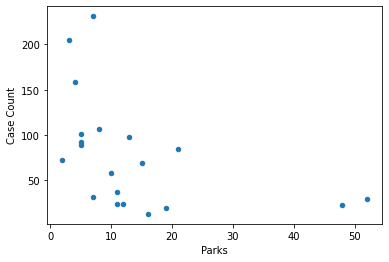

In [37]:
df.plot.scatter(x='Parks', y='Case Count')

On visual inspection it does look, roughly, like we have a negative correlation between accessible parks and COVID-19 case counts. In particular, it looks like a negative exponential function. We will fit both a linear and non-linear regression for comparision in which we see whether the number of close parks to a neighborhood affects the incidence of COVID-19.

### Linear Regression

We start by fitting a linear model with number of accessible parks as the independent variable and COVID case count as the dependent variable.

In [234]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lm = LinearRegression()

df = df.sort_values(by='Parks')

X = df[['Parks']]
Y = df['Case Count']

In [235]:
lm.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The regression line roughly follows the negative trend of the data.

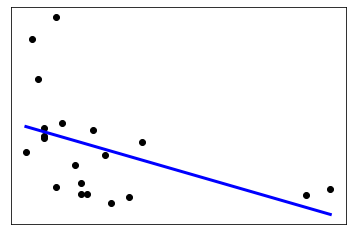

In [197]:
plt.scatter(X, Y,  color='black')
plt.plot(X, lm.predict(X), color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

The r-square value for the model is low, but perhaps that is to be expect. There is no way that we should expect that park locations to account for most of the variation in COVID cases by neighborhood. We mostly care about the positive or negative correlation. Here we find a negative correlation that accounts for some of the variation.

In [236]:
# The coefficients
print('Coefficients: \n', lm.coef_)

print('R2: \n', r2_score(Y, lm.predict(X)))

Coefficients: 
 [-2.05606963]
R2: 
 0.20554929037065095


We have fit a linear model, but is the linear assumption warranted? Below we have a plot of the residuals. They do not look evenly distributed around the 0 point. We have two clumps and more points below the line than above. This suggests that we should not fit linear model. In response to this plot, we fit a polynomial model below.

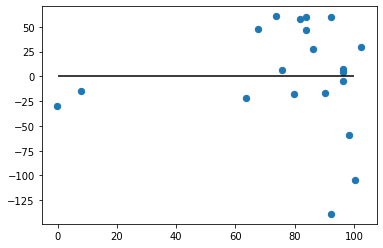

In [198]:
plt.scatter(lm.predict(X), lm.predict(X) - Y, s=40)
plt.hlines(y=0,xmin=0,xmax=100)

### The polynomial model

We start by fitting a low-degree polynomial model of degree 3. We do not have a lot of data, and so higher degree models will be prone to overfitting.

In [237]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_ = poly.fit_transform(X)

polm = LinearRegression()
polm.fit(X_,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The regression line looks more resonable here, tracking the curvilinear structure of the data---e.g., relatively more mass below 10, relatively less mass above 40

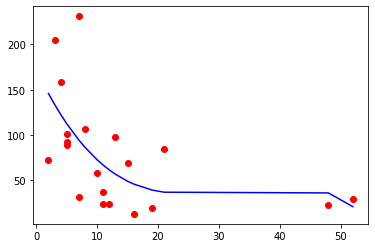

In [241]:
plt.scatter(X,Y,color='red')
plt.plot(X,polm.predict(poly.fit_transform(X)),color='blue')

The r-squared value shows better fit than the linear model. Once again, it is quite low, but we don't expect for this variable to actual predict most of the variance.

In [239]:
# The coefficients
print('Coefficients: \n', polm.coef_)

print('R2: \n', r2_score(Y, polm.predict(poly.fit_transform(X))))

Coefficients: 
 [ 0.00000000e+00 -1.41986155e+01  4.71859158e-01 -4.89992742e-03]
R2: 
 0.35131685928085743


Finally, we plot the residuals again. What we find is a much more satisfying plot, with residuals evenly distributed around possible values with no clear structure. This suggests the polynomial assumption is reasonable.

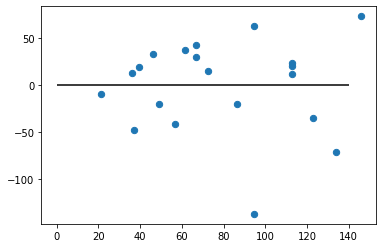

In [232]:
plt.scatter(polm.predict(poly.fit_transform(X)), polm.predict(poly.fit_transform(X)) - Y, s=40)
plt.hlines(y=0,xmin=0,xmax=140)

## Discussion

We began with a critical and pointed public health question. Are parks dangerous? That is, does easy access to public spaces where people can congregate increase the incidence of COVID-19 in a neighborhood. Based on the data we collected, the our core chat, below, **answers the question negatively. That is, there is not a positive relationship between accessible parks and the prevalence of COVID cases in a neighborhood.**

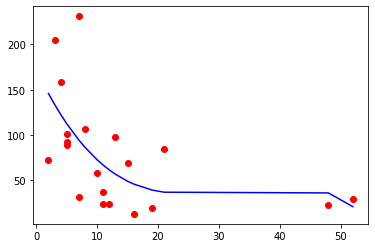

In [245]:
plt.scatter(X,Y,color='red')
plt.plot(X,polm.predict(poly.fit_transform(X)),color='blue')

## Conclusion

We have given a proof of concept that the venue-geography of a region (as given by Foursquare) can reveal structure in the the prevalence of COVID-19 across a city. More narrowly, we have shown that parks are at least not clearly dangerous. There is definitely more work to do. First, we might wonder what accounts for the negative correlation we see? That is, why does access to parks appear to lower the amount of COVID-19 in a community? There are a couple hypothesis. First, neighborhoods with lots of parks are often desirable places to live, and so more expensive. We could be seeing an effect of wealth, that is richer people are less likely to contract COVID, and they live near parks. At the tail end, where there are many accessible parks and very low COVID incidence, we could be seeing the effect of density. That is, if there are so many parks nearby perhaps there just aren't that many people who permanently live in the neighborhood, and so not that many people to get ill. Teasing apart these confounds will require more data for controls, but we can at least say at this point that access to parks is not causing such an increase in COVID cases that it is overwhelming other sources of variance.